## Importing Library


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## DataSet Load

In [122]:
batch_size=128
test_batch_size=256

transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.1307,), (0.3081,))])

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=True, download=True, 
                 transform=transform), 
    batch_size = batch_size, shuffle=True, )

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
                 transform=transform), 
    batch_size=test_batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


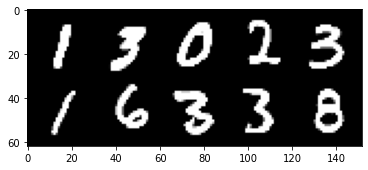

In [123]:
import torchvision
import matplotlib.pyplot as plt
batch_tensor = next(iter(train_loader))[0][0:10]   # (N, C, H, W)

# make grid (2 rows and 5 columns) to display our 10 images
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)

# reshape and plot (because MPL needs channel as the last dimension)
plt.imshow(grid_img.permute(1, 2, 0))


## Set Simple Model

In [5]:
model=nn.Sequential(nn.Flatten(),nn.Linear(28*28,10),nn.Softmax(dim=1))
model

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): Softmax(dim=1)
)

# Train Model

In [7]:
#Train Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)
log_step=200
epochs=5
optimizer=optim.Adam(model.parameters(),lr=0.01)
crit=nn.CrossEntropyLoss()

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    avg_valid_loss=0
    correct=0
    model.train()
    for idx,(img,label) in enumerate(train_loader):
        optimizer.zero_grad()
        img=img.to(device)
        label=label.to(device)
        out=model(img)
        loss=crit(out,label)
        loss.backward()
        optimizer.step()
        if idx%log_step==0:
            print(f'{idx}/{len(train_loader)} | Loss: {loss.item()}')
    model.eval()  
    with torch.no_grad():        
        for idx,(img,label) in enumerate(test_loader):
            img=img.to(device)
            label=label.to(device)
            out=model(img)
            loss=crit(out,label)
            pred = out.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
            avg_valid_loss+=loss.item()
    print(f'Avg Loss: {avg_valid_loss/len(test_loader)}')
    print(f'Avg Accuracy: {correct/(len(test_loader.dataset))}')
               
#Save Model
model=model.to("cpu")
torch.save(model.state_dict(),"model.ckpt")

Epoch: 0
0/469 | Loss: 2.301548480987549
200/469 | Loss: 1.5424129962921143
400/469 | Loss: 1.5491101741790771
Avg Loss: 1.5490523636341096
Avg Accuracy: 0.9161
Epoch: 1
0/469 | Loss: 1.5757266283035278
200/469 | Loss: 1.586740493774414
400/469 | Loss: 1.5701186656951904
Avg Loss: 1.5447520047426224
Avg Accuracy: 0.9185
Epoch: 2
0/469 | Loss: 1.5150330066680908
200/469 | Loss: 1.5792585611343384
400/469 | Loss: 1.5458050966262817
Avg Loss: 1.5424275070428848
Avg Accuracy: 0.9183
Epoch: 3
0/469 | Loss: 1.5515344142913818
200/469 | Loss: 1.4764918088912964
400/469 | Loss: 1.5258203744888306
Avg Loss: 1.5405279666185379
Avg Accuracy: 0.9205
Epoch: 4
0/469 | Loss: 1.5451754331588745
200/469 | Loss: 1.5281215906143188
400/469 | Loss: 1.5747061967849731
Avg Loss: 1.5406770676374435
Avg Accuracy: 0.924


In [124]:
model.load_state_dict(torch.load("model.ckpt"))

<All keys matched successfully>

# Find Adversarial Example

In [126]:
data.requires_grad = True
label=label
model.train()
pert_list=[]
pertubed_img_list=[]
for epsilon in [0.01]:
    for idx,(data,label) in enumerate(test_loader.dataset):
        data.requires_grad = True
        out=model(data.unsqueeze(0))
        loss = nn.CrossEntropyLoss()(out, torch.tensor(label).unsqueeze(0))
        model.zero_grad()
        loss.backward()
        
        initial_pred = out.max(1, keepdim=True)[1].item()
        if initial_pred==label:
            data_grad = data.grad.data
            
            # FGSM Method
            pert=epsilon*data_grad.sign()
            
            pertubed_img=data+pert

            new_out=model(pertubed_img)
            new_pred = new_out.max(1, keepdim=True)[1].item()

            if new_pred !=initial_pred:
                print(f"Found error with epsilon:{epsilon}, idx={idx}")
                pert_list.append(pert)
                pertubed_img_list.append(pertubed_img)
                break
    

    


Found error with epsilon:0.01, idx=73


## Visualization

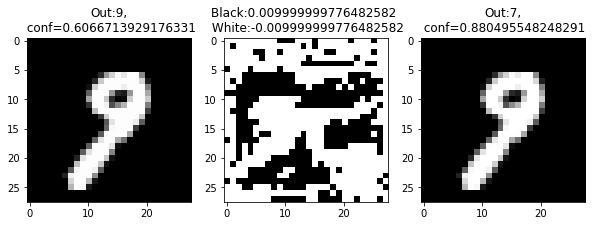

In [127]:
fig,ax=plt.subplots(ncols=3,figsize=(10,15))

ax[0].set_title(f'Out:{initial_pred},\n conf={out[0][initial_pred]}')
ax[0].imshow(transforms.ToPILImage()(data*0.13+0.308),cmap='gray')
ax[1].set_title(f'Black:{pert.max()} \n White:{pert.min()}')

ax[1].imshow(transforms.ToPILImage()(pert),cmap='gray')

ax[2].set_title(f'Out:{new_pred},\n conf={new_out[0][new_pred]}')

ax[2].imshow(transforms.ToPILImage()(pertubed_img*0.13+0.308),cmap='gray')